![](Rydiqule_Logo_Transparent_300.png)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import matplotlib.pyplot as plt

In [3]:
import rydiqule as rq
from rydiqule.sensor_utils import get_rho_ij

# Two dimensional hybrid doppler

This example follows the experimental setup in Glick et al. (https://arxiv.org/pdf/2506.04504). It is a $Rb^{85}$ vapor with a $5S_{1/2} \rightarrow 5P_{1/2} \rightarrow 6S_{1/2} \rightarrow 31P_{1/2}$ excitation pathway and corresponding optical fields of 795 nm, 1324 nm, and 745 nm. These fields are called probe, dressing, and Rydberg, respectively.

We simulate the EIT spectra of the collinear and Doppler-free configurations using the solve_doppler_hybrid function that solves the collinear configuration analytically and the Doppler-free configuration using a hybrid analytic/numeric method.

In [4]:
# parameters for Cell
atom = 'Rb85'

states = [
    rq.A_QState(5,0,1/2),
    rq.A_QState(5,1,1/2),
    rq.A_QState(6,0,1/2),
    rq.A_QState(31,1,1/2)
]

sensor = rq.Cell(atom, states)

In [5]:
# laser parameters
detunings = 2*np.pi*np.linspace(-10,10,201)
Omega_p = 2*np.pi*2
Omega_d = 2*np.pi*10
Omega_R = 2*np.pi*1

## Collinear configuration

In [6]:
kunit1 = np.array([-1,0,0])
kunit2 = np.array([1,0,0])

probe = {'states': (states[0],states[1]), 'detuning': 0, 'rabi_frequency': Omega_p, 'kunit': kunit1}
dressing = {'states': (states[1],states[2]), 'detuning': 0, 'rabi_frequency': Omega_d, 'kunit': kunit1}
Rydberg = {'states': (states[2],states[3]), 'detuning': detunings, 'rabi_frequency': Omega_R, 'kunit': kunit2}

sensor.add_couplings(probe, dressing, Rydberg)
sols_col = rq.solve_doppler_hybrid(sensor)

## Doppler-free configuration

In this configuration, we show the ability of rydiqule to solve systems using a hybrid analytic/numeric approach, where one user-designated spatial dimension is averaged analytically and the other is averaged numerically. 

In [7]:
theta = 4.526
phi = 2.556

kunit1 = np.array([-1,0,0])
kunit2 = np.array([-1*np.cos(theta),-1*np.sin(theta),0])
kunit3 = np.array([-1*np.cos(phi),-1*np.sin(phi),0])

probe = {'states': (states[0],states[1]), 'detuning': 0, 'rabi_frequency': Omega_p, 'kunit': kunit1}
dressing = {'states': (states[1],states[2]), 'detuning': 0, 'rabi_frequency': Omega_d, 'kunit': kunit2}
Rydberg = {'states': (states[2],states[3]), 'detuning': detunings, 'rabi_frequency': Omega_R, 'kunit': kunit3}

sensor.add_couplings(probe, dressing, Rydberg)

In [8]:
sols_DF = rq.solve_doppler_hybrid(sensor, analytic_axis=0)
sols_DF_1 = rq.solve_doppler_hybrid(sensor, analytic_axis=1)

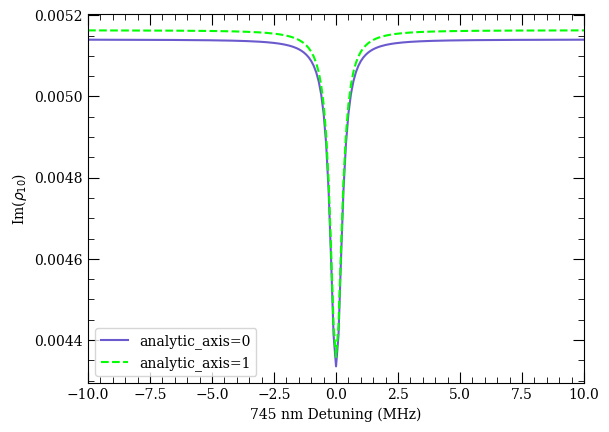

In [9]:
fig, ax = plt.subplots()
ax.plot(detunings/(2*np.pi), get_rho_ij(sols_DF.rho,1,0).imag, c='slateblue', label="analytic_axis=0")
ax.plot(detunings/(2*np.pi), get_rho_ij(sols_DF_1.rho,1,0).imag, c='lime', linestyle='dashed', label="analytic_axis=1")
ax.set_xlabel("745 nm Detuning (MHz)")
ax.set_xlim(-10,10)
ax.set_ylabel(r"Im($\rho_{10}$)")
ax.legend()

Note that, for some systems, the default mesh is not sufficient to properly capture the tails of the velocity distribution. That is, the distribution normalizes to something slightly less than one. Because the analytic method is much higher accuracy, this can cause a noticeable shift in the solutions depending on which axis is sampled. This can be remedied by increasing the `width_doppler` in the mesh method on the numeric axis.

In [10]:
m = {"method":"split", "width_doppler":2.5}
sols_DF = rq.solve_doppler_hybrid(sensor, analytic_axis=0, doppler_mesh_method=m)
sols_DF_1 = rq.solve_doppler_hybrid(sensor, analytic_axis=1, doppler_mesh_method=m)

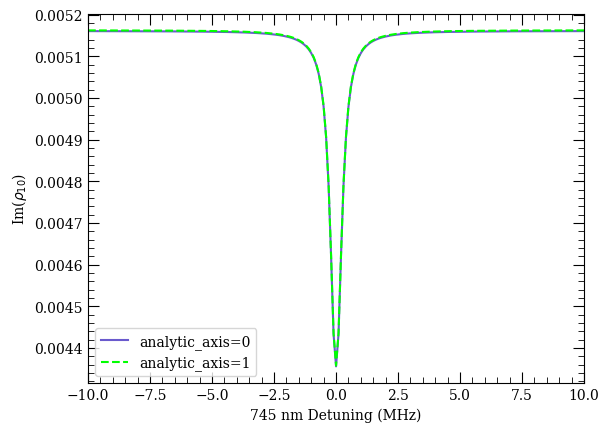

In [11]:
fig, ax = plt.subplots()
ax.plot(detunings/(2*np.pi), get_rho_ij(sols_DF.rho,1,0).imag, c='slateblue', label="analytic_axis=0")
ax.plot(detunings/(2*np.pi), get_rho_ij(sols_DF_1.rho,1,0).imag, c='lime', linestyle='dashed', label="analytic_axis=1")
ax.set_xlabel("745 nm Detuning (MHz)")
ax.set_xlim(-10,10)
ax.set_ylabel(r"Im($\rho_{10}$)")
ax.legend()

We can then recreate Figure 5 in the Glick et al. paper.

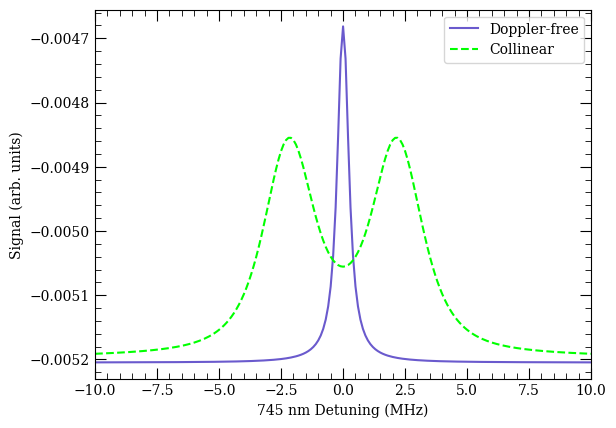

In [12]:
fig, ax = plt.subplots()
ax.plot(detunings/(2*np.pi), (-.65*get_rho_ij(sols_DF.rho,1,0).imag-.00185), c='slateblue', label="Doppler-free")
ax.plot(detunings/(2*np.pi), -1*get_rho_ij(sols_col.rho,1,0).imag, c='lime', linestyle='dashed', label="Collinear")
ax.set_xlabel("745 nm Detuning (MHz)")
ax.set_xlim(-10,10)
ax.set_ylabel(r"Signal (arb. units)")
ax.legend()

## Computation time and memory footprint improvements

We now show the decrease in both computation time and required memory footprint of the hybrid method in comparison to the existing numeric method.

In [13]:
%%time
sols_DF_riemann = rq.solve_steady_state(sensor, doppler=True, doppler_mesh_method=m)

Breaking equations of motion into 2 sets of equations...
CPU times: total: 3min 1s2
Wall time: 2min 59s


In [14]:
%%time
sols_DF = rq.solve_doppler_hybrid(sensor, analytic_axis=0, doppler_mesh_method = m)

CPU times: total: 5.89 s
Wall time: 4.87 s


In [22]:
from rydiqule.slicing.slicing import get_slice_num, get_slice_num_hybrid

get_slice_num(n=sensor.basis_size, stack_shape = (201,), doppler_shape=(601, 601), sum_doppler=True, weight_doppler=True, debug=True)

Total available memory: 115.15 GiB
Min Req memory to solve: 0.68633 GiB
Req memory per EOM: 0.68626 GiB
Req memory for full solve: 137.94 GiB
	Mandatory memory use: 7.0386e-05 GiB
	Memory use for all EOMs: 137.94 GiB
	Full output solution size: 2.2464e-05 GiB
Available memory for sliced solves: 115.15 GiB
Number of stack slices to be used: 2


(2, (201, 15))

In [23]:
get_slice_num_hybrid(n=sensor.basis_size, param_stack_shape=(201,), numeric_doppler_shape=(601,), debug=True)

--- Hybrid Solver Memory Debug ---
Total available RAM: 115.2 GiB
Min Req memory to solve: 0.01075 GiB
Req memory for full solve: 2.16 GiB
	Full output solution size: 2.3961e-05 GiB
Available memory for sliced calculations: 115.2 GiB
Calculated minimum slices needed: 1.0
Final number of slices to be used: 1
------------------------------------


(1, (201, 16))

In [24]:
print(f'Wall time reduced by x{3*60/5:.0f}')
print(f'Solve memory requirement reduced by x{137.94/2.16:.0f}')

Wall time reduced by x36
Solve memory requirement reduced by x64


In [25]:
rq.about()


        Rydiqule
    
Rydiqule Version:     2.1.0.dev42+g8955c712
Installation Path:    ~\src\rydiqule_public\src\rydiqule

      Dependencies
    
NumPy Version:        1.26.4
SciPy Version:        1.12.0
Matplotlib Version:   3.8.0
ARC Version:          3.6.0
Python Version:       3.11.8
Python Install Path:  ~\Miniconda3\envs\rq
Platform Info:        Windows (AMD64)
CPU Count and Freq:   12 @ 3.60 GHz
Total System Memory:  128 GB
